In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from methods import *

dataset_path = Path("dataset")
dataset = LabeledDataset(dataset_path=dataset_path)
dataset_unchanged = LabeledDataset(dataset_path=dataset_path, uniform_size=False, new_size=None)


Rozdział na SPLIT1/SPLIT2 train/val/test

In [2]:
class Split(NamedTuple):
    train: LabeledDataset
    val: LabeledDataset
    test: LabeledDataset


splits = [Split(*dataset_unchanged.split_dataset()), Split(*dataset.split_dataset())]

Augmentacja train dataset poprzez rotacje (chwilę trwa, lepiej wczytać już wygenerowany)

In [3]:
import shutil
import scipy.ndimage

train = splits[1].train

def augment(data):
    rotations_per_image = 2
    augment_count = len(data)

    rng = np.random.default_rng(seed=666_666)

    label_sizes = {Label.PAPER: augment_count // 3, Label.ROCK: augment_count // 3}
    label_sizes[Label.SCISSORS] = augment_count - sum(label_sizes.values())

    random_images = {
        label: rng.choice(data[label], size=label_sizes[label], replace=False)
        for label in Label
    }

    def rotate(image, angle):
        return scipy.ndimage.rotate(image, angle, reshape=False, mode="nearest")

    import time
    start = time.time()

    augmented_images = {
        label: [
            rotate(image, angle) for image in random_images[label] for angle in rng.choice(range(1, 360), size=rotations_per_image)
            ] for label in Label
        }
    print(time.time() - start)
    return augmented_images

augmented_dir = Path("dataset/augmented")
force_gen = False

if force_gen == False and augmented_dir.exists():
    augmented = LabeledDataset(dataset_path=augmented_dir)
else:
    augmented = augment(train)
    shutil.rmtree(augmented_dir, ignore_errors=True)
    for label, images in augmented.items():
        label_dir = augmented_dir / label.name.lower()
        label_dir.mkdir(parents=True, exist_ok=True)
        index = 1
        for image in images:
            cv2.imwrite(str(label_dir / f'{index:04}.png'), image)
            index += 1
        for image in train[label]:
            cv2.imwrite(str(label_dir / f'{index:04}.png'), image)
            index += 1

    augmented = LabeledDataset(dataset_path=augmented_dir)

splits[1] = Split(augmented.copy(), splits[1].val, splits[1].test)


Normalizacja

In [4]:
_, mean, std = splits[1].train.normalize(inplace=True)
_, _, _ = splits[1].val.normalize(mean=mean, std=std, inplace=True)
_, _, _ = splits[1].test.normalize(mean=mean, std=std, inplace=True)

# TODO: Change val split so it's made from train (and preferably with uniform label distribution)
splits.append(Split(splits[1].train, splits[1].val, splits[1].test))

Liczba danych wejściowych (przed i po obróbce (scale & uniform)):

In [5]:
from tabulate import tabulate
counts = {
        label.name: [
            len(dataset_unchanged[label]),
            len(dataset[label]),
            len(splits[0].train[label]),
            len(splits[0].val[label]),
            len(splits[0].test[label]),
            len(splits[1].train[label]),
            len(splits[1].val[label]),
            len(splits[1].test[label]),
        ]
        for label in Label
    }
counts["TOTAL"] = [sum(column) for column in zip(*counts.values())]


counts = [[key, *counts[key]] for key in counts.keys()]

print(tabulate(counts, headers=[
    "LABEL", "przed obróbką", "po obróbce", *[f"split{i+1} {split_set}" for i in range(2) for split_set in ["train", "val", "test"]]
    ]))

LABEL       przed obróbką    po obróbce    split1 train    split1 val    split1 test    split2 train    split2 val    split2 test
--------  ---------------  ------------  --------------  ------------  -------------  --------------  ------------  -------------
ROCK                  726           712             508           145             73            1494           142             72
PAPER                 712           712             498           142             72            1494           142             72
SCISSORS              750           712             525           150             75            1494           142             72
TOTAL                2188          2136            1531           437            220            4482           426            216


Kilka losowo wybranych zdjęć:

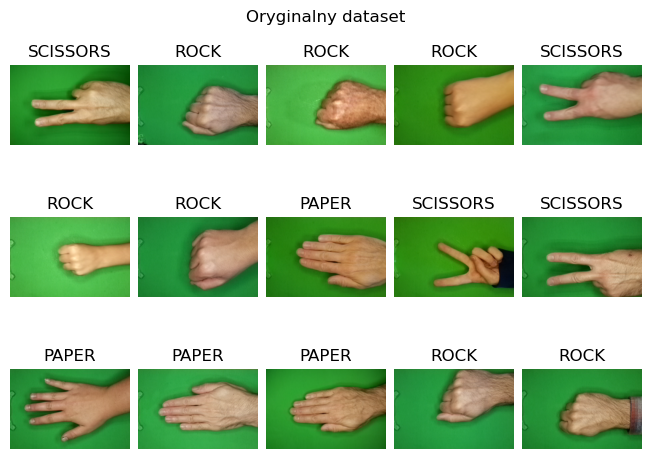

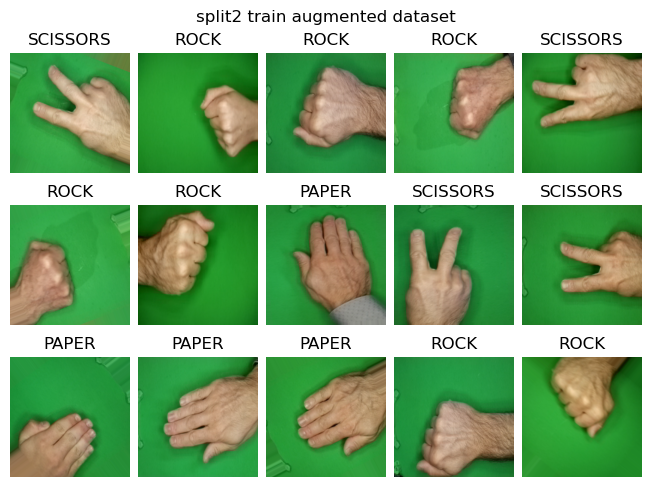

In [6]:
def draw_random_images(data, title):
    fig, ax = plt.subplots(3,5, constrained_layout=True)
    fig.suptitle(title)
    rng = np.random.default_rng(seed=2222)
    random_indices = rng.choice(len(data), 5*3)
    for row in range(3):
        for col in range(5):
            index = row*5 + col
            ax[row][col].set_axis_off()
            random_image = data[random_indices[index]]
            ax[row][col].imshow(random_image[...,::-1])
            for label, label_range in data._label_ranges.items():
                if label_range.start <= random_indices[index] < label_range.end:
                    ax[row][col].set_title(label.name)
                    break

draw_random_images(dataset_unchanged, "Oryginalny dataset")
draw_random_images(augmented, "split2 train augmented dataset")


Zdjęcia zostały spłaszczone do rozmiaru 200x200:

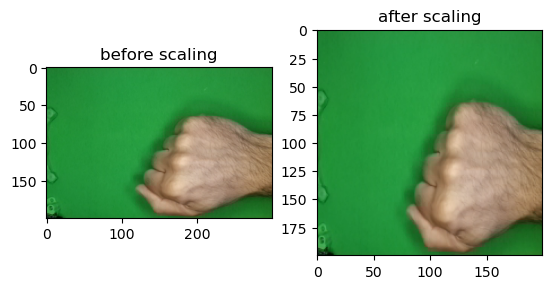

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title("before scaling")
ax[1].set_title("after scaling")

# change BGR to RGB before displaying
_ = ax[0].imshow(dataset_unchanged[0][...,::-1])
_ = ax[1].imshow(dataset[0][...,::-1])

Histogramy dla różnych labeli, dla każdego kanału

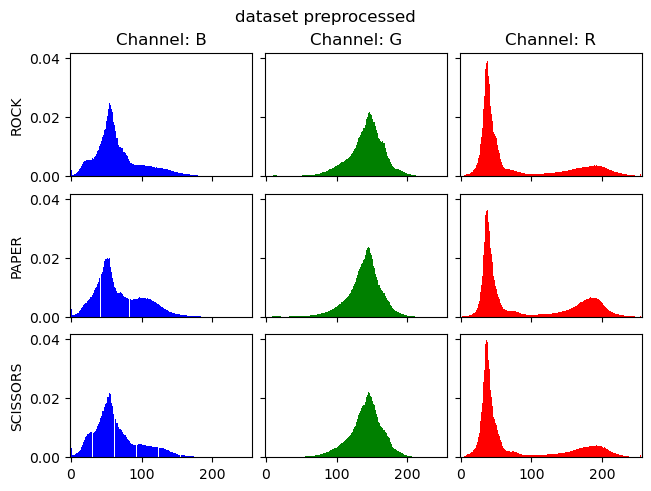

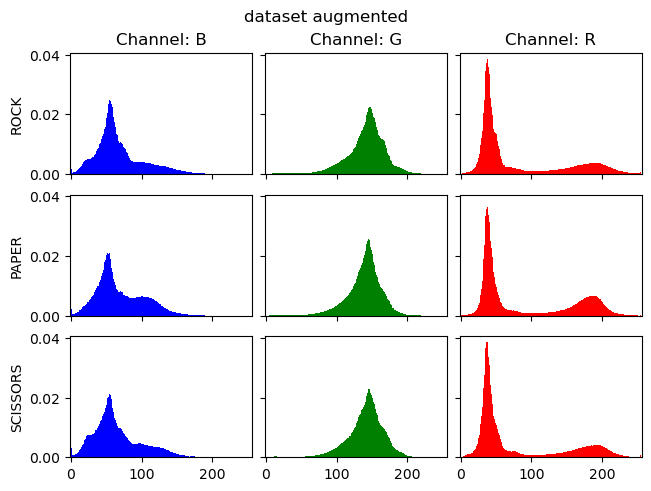

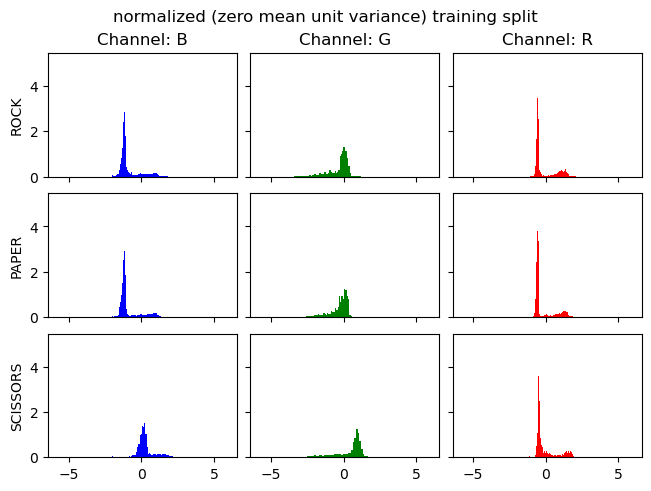

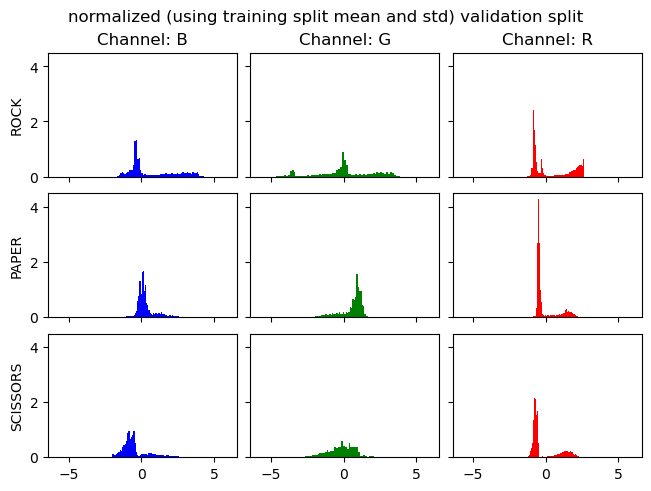

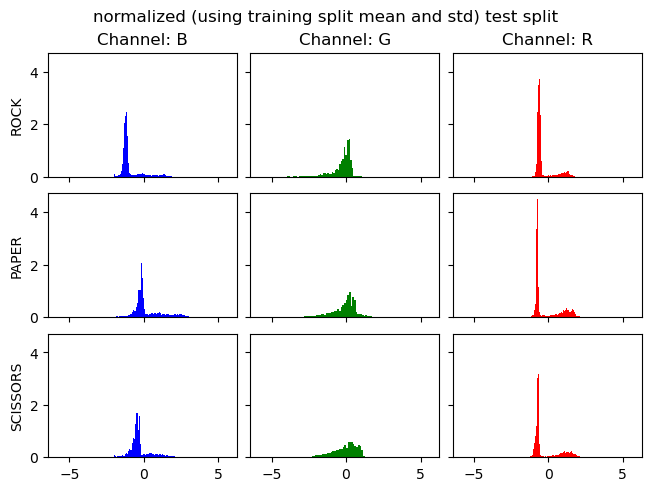

In [8]:
from typing import OrderedDict

def hist(data, title, min_val = 0, max_val = 255, bins = 255):
    reshaped = OrderedDict()

    # merge all pixels into one dimension (image, width and height dimensions)
    for label in Label:
        reshaped[label] = data[label].reshape((-1, 3))

    fig, ax = plt.subplots(3,3, sharex=True, sharey=True, constrained_layout=True)
    fig.suptitle(title)
    for i, label in enumerate(reshaped):
        for color in Channel:
            ax[i][color].set_xlim([min_val - 1, max_val + 1])
            _ = ax[i][color].hist(reshaped[label][:, color], density=True, bins=bins, color=color.name.lower())

    for i in range(3):
        ax[0][i].set_title(f"Channel: {Channel(i).name}")
        ax[i][0].set_ylabel(list(Label)[i].name)

hist(dataset, "dataset preprocessed")
hist(augmented, "dataset augmented")
hist(splits[1].train.data, "normalized (zero mean unit variance) training split", np.min(splits[1].train.data), np.max(splits[1].train.data), 64)
hist(splits[1].val.data, "normalized (using training split mean and std) validation split", np.min(splits[1].val.data), np.max(splits[1].val.data), 64)
hist(splits[1].test.data, "normalized (using training split mean and std) test split", np.min(splits[1].test.data), np.max(splits[1].test.data), 64)

Wariancja

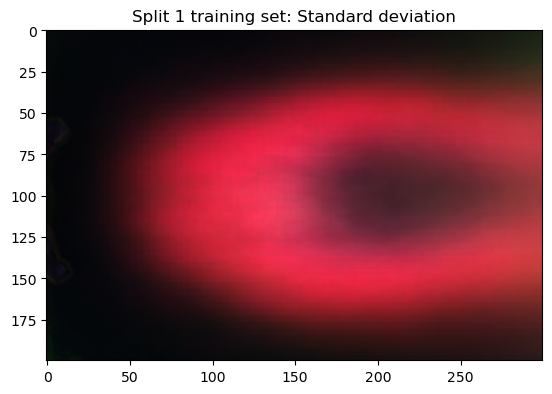

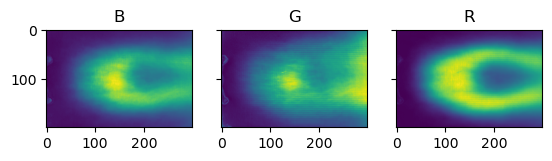

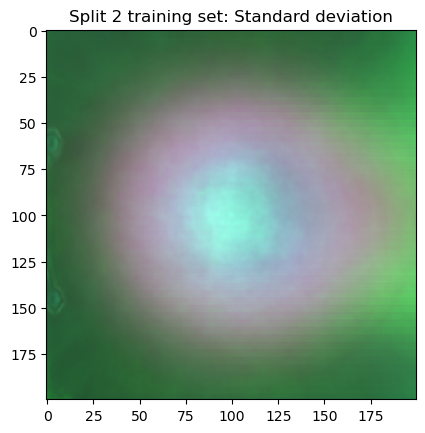

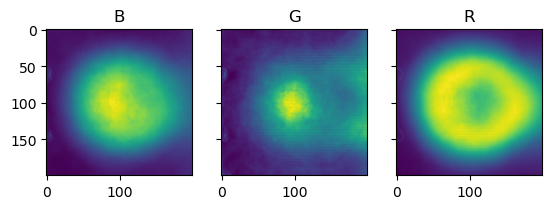

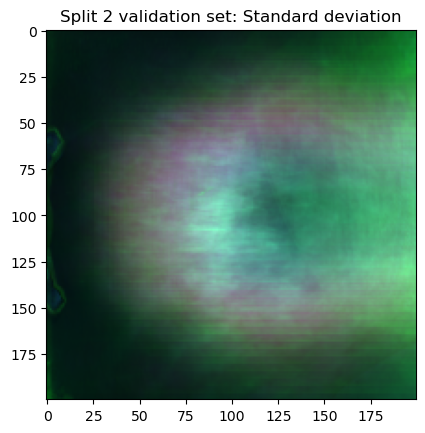

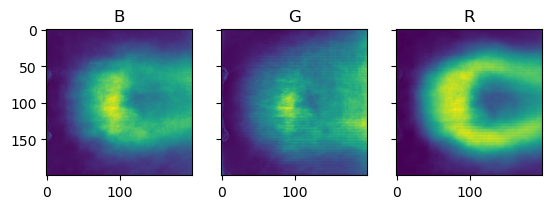

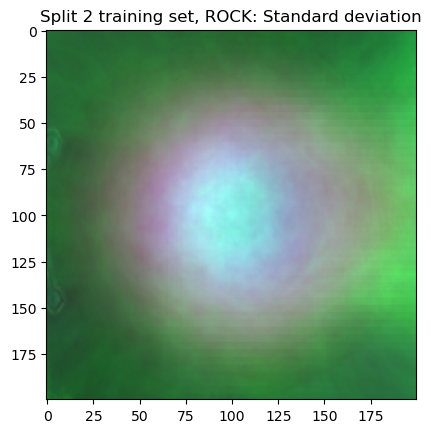

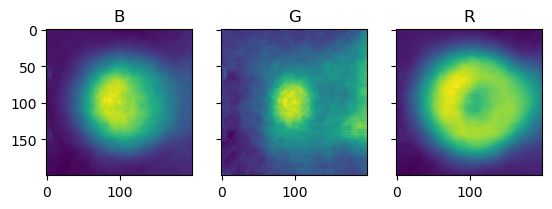

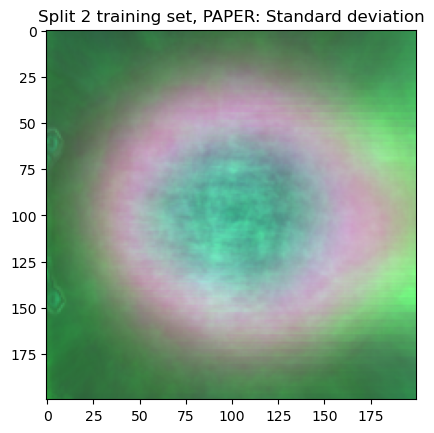

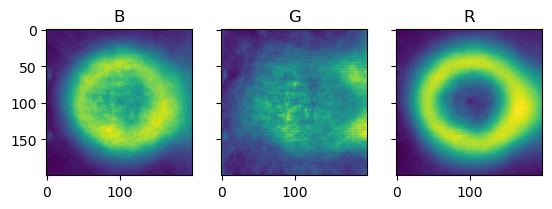

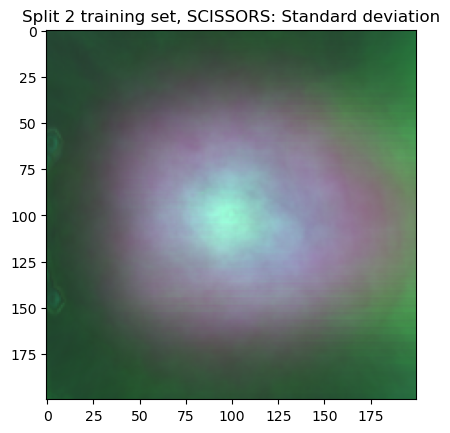

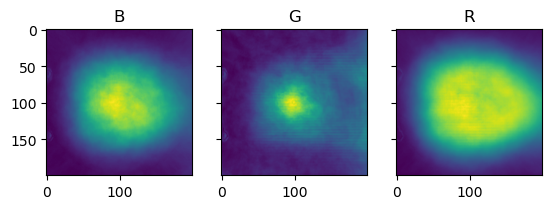

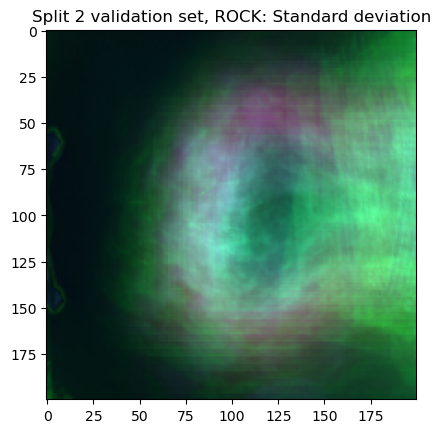

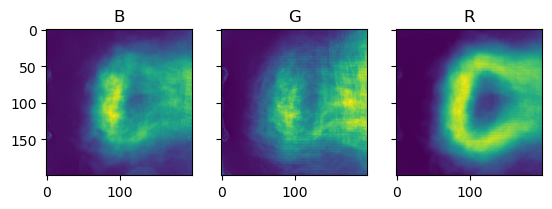

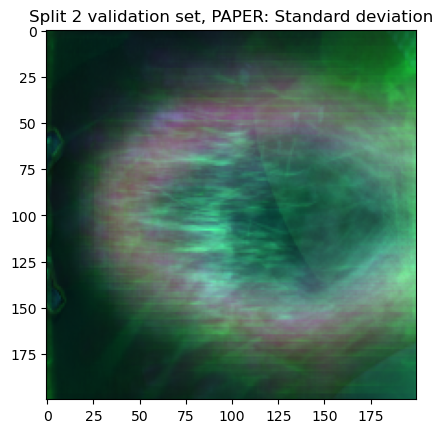

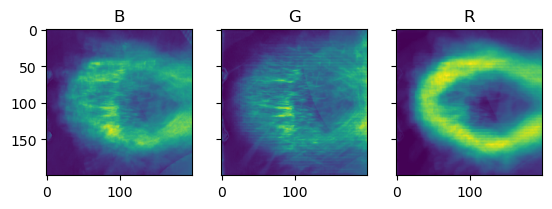

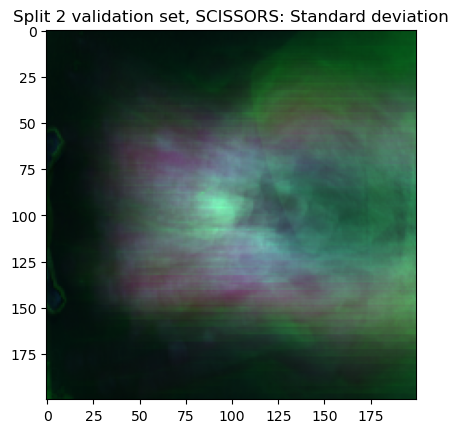

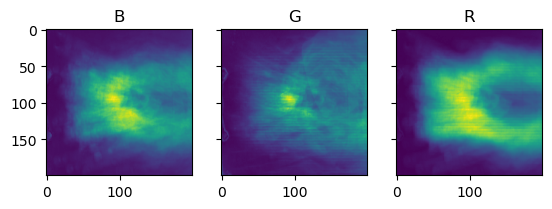

In [9]:
def show_std(data, title):
    std = np.std(data, axis=0)
    std = (std**2)
    std = std / np.max(std)

    plt.imshow(std[...,::-1])
    _ = plt.title(f"{title}: Standard deviation")

    _, ax = plt.subplots(1, 3, sharey=True)
    for i, channel in enumerate(Channel):
        ax[i].imshow(std[..., channel])
        ax[i].set_title(channel.name)
    plt.show()

split1_train = splits[0].train
split2_train = splits[1].train
split2_val =   splits[1].val
show_std(split1_train.data, "Split 1 training set")
show_std(split2_train.data, "Split 2 training set")
show_std(split2_val.data, "Split 2 validation set")

for label in Label:
    show_std(split2_train[label], f"Split 2 training set, {label.name}")
for label in Label:
    show_std(split2_val[label], f"Split 2 validation set, {label.name}")